In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/windows-malwares/PE_Section.csv
/kaggle/input/windows-malwares/DLLs_Imported.csv
/kaggle/input/windows-malwares/API_Functions.csv
/kaggle/input/windows-malwares/PE_Header.csv


# Data Engineering

In [2]:
# Paths to the four CSVs from above
p_dlls   = "/kaggle/input/windows-malwares/DLLs_Imported.csv"
p_api    = "/kaggle/input/windows-malwares/API_Functions.csv"
p_hdr    = "/kaggle/input/windows-malwares/PE_Header.csv"
p_sect   = "/kaggle/input/windows-malwares/PE_Section.csv"

## Check Binary/Continuous Features for Each Dataset

In [3]:
# Helper: read CSV and lower-case/normalize column names
def read_norm(path):
    df = pd.read_csv(path, low_memory=False)
    df.columns = [c.strip().lower() for c in df.columns]
    return df

dlls  = read_norm(p_dlls)
api   = read_norm(p_api)
hdr   = read_norm(p_hdr)
sect  = read_norm(p_sect)

In [4]:
def column_type_summary(df, name):
    binary_cols = []
    continuous_cols = []

    for col in df.columns:
        if col.lower() in ['sha256', 'type']:
            continue
        vals = df[col].dropna().unique()
        if set(vals).issubset({0, 1}):
            binary_cols.append(col)
        else:
            continuous_cols.append(col)

    print(f"--- {name} ---")
    print(f"Rows:               {len(df):>7,}")
    print(f"Binary columns:     {len(binary_cols):>7}")
    print(f"Continuous columns: {len(continuous_cols):>7}")
    print(f"Total feature cols: {len(df.columns) - 2:>7}")  # excluding sha256 + type
    print(f"Total columns:      {len(df.columns):>7}\n")

    return binary_cols, continuous_cols

# Binary Datasets
dlls_bin, dlls_cont = column_type_summary(dlls, "p_dlls")
api_bin, api_cont   = column_type_summary(api,  "p_api")

# Continuous Datasets
hdr_bin, hdr_cont   = column_type_summary(hdr,  "p_hdr")
sect_bin, sect_cont = column_type_summary(sect, "p_sect")


--- p_dlls ---
Rows:                29,498
Binary columns:         629
Continuous columns:       0
Total feature cols:     629
Total columns:          631

--- p_api ---
Rows:                29,505
Binary columns:       21918
Continuous columns:       0
Total feature cols:   21918
Total columns:        21920

--- p_hdr ---
Rows:                29,807
Binary columns:           1
Continuous columns:      51
Total feature cols:      52
Total columns:           54

--- p_sect ---
Rows:                29,760
Binary columns:           8
Continuous columns:      82
Total feature cols:      90
Total columns:           92



## Merge Respective Binary/Continuous Datasets (Binary: APIs + DLLs | Continuous: PE_Header + PE_Sections)

In [5]:
# Ensure the join key is present and normalized
for df in [dlls, api, hdr, sect]:
    assert 'sha256' in df.columns, f"'sha256' not found in {df.shape}"

# (Optional) cast 0/1 feature columns to smaller ints to save RAM
def cast_binary(df):
    for c in df.columns:
        if c not in ('sha256', 'type'):
            # Try to downcast to uint8 if it looks like binary
            if df[c].dropna().isin([0,1]).all():
                df[c] = df[c].astype('uint8')
    return df

dlls = cast_binary(dlls)
api  = cast_binary(api)
# hdr/sect are numeric counts/sizes; let pandas infer first (or downcast later)

In [6]:
from functools import reduce

# Keep 'type' only once; check for mismatches first.
def label_map(df):
    return df[['sha256', 'type']].drop_duplicates()

### Binary: (APIs + DLLs)

In [7]:
lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([dlls, api])]
lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# If all labels match per sha256, each row should have identical values across type_* columns
mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
print("Label mismatches:", mismatch.sum())
# If mismatches==0, we can safely keep one 'type' column later.

Label mismatches: 0


In [8]:
binary_df = dlls.merge(api, on=['sha256', 'type'], how='inner')

# drop duplicate columns
dupe_cols = [c for c in binary_df.columns if c.startswith('type') and c != 'type']
binary_df.drop(columns=dupe_cols, inplace=True, errors='ignore')

print(binary_df.shape)

(29502, 22533)


### Continuous: (PE Header + PE Sections)

In [9]:
lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([hdr, sect])]
lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# If all labels match per sha256, each row should have identical values across type_* columns
mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
print("Label mismatches:", mismatch.sum())
# If mismatches==0, we can safely keep one 'type' column later.

Label mismatches: 0


In [10]:
cont_df = hdr.merge(sect, on=['sha256', 'type'], how='inner')

# drop duplicate columns
dupe_cols = [c for c in cont_df.columns if c.startswith('type') and c != 'type']
cont_df.drop(columns=dupe_cols, inplace=True, errors='ignore')

print(cont_df.shape)

(29514, 144)


## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

bin_X_all = binary_df.drop(['sha256', 'type'], axis=1)
bin_Y_all = binary_df['type'].apply(lambda v: 0 if v == 0 else 1)
bin_correlations = bin_X_all.corrwith(bin_Y_all)
bin_correlations_abs = bin_correlations.abs()
top15 = bin_correlations_abs.sort_values(ascending=False).head(15).index.tolist()
print("Top 15 Features:", top15)
print("\n")

bin_X = binary_df[top15]
bin_Y = binary_df['type'].apply(lambda v: 0 if v == 0 else 1)

bin_X_trainval, bin_X_test, bin_Y_trainval, bin_Y_test = train_test_split(
    bin_X, bin_Y, test_size=0.15, random_state=42, stratify=bin_Y
)
val_fraction = 0.15 / 0.85
bin_X_train, bin_X_val, bin_Y_train, bin_Y_val = train_test_split(
    bin_X_trainval, bin_Y_trainval, test_size=val_fraction, random_state=42, stratify=bin_Y_trainval
)
print("Training set:", bin_X_train.shape)
print("Validation set:", bin_X_val.shape)
print("Test set:", bin_X_test.shape)


bin_clf = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    max_iter=500,
    class_weight='balanced',
    random_state=42
)
bin_clf.fit(bin_X_train, bin_Y_train)

Top 15 Features: ['cspecifichandler', 'rtlvirtualunwind', 'rtllookupfunctionentry', 'fmode', 'rtlcapturecontext', 'iobfunc', 'free', 'malloc', 'amsgexit', 'cexit', 'lock', 'unlock', 'rtladdfunctiontable', 'fprintf', 'calloc']


Training set: (20650, 15)
Validation set: (4426, 15)
Test set: (4426, 15)


LogisticRegression(class_weight='balanced', max_iter=500, penalty='l1',
                   random_state=42, solver='liblinear')

In [12]:
print("Training accuracy: {:.2f}%".format(bin_clf.score(bin_X_train, bin_Y_train)*100))
print("Validation accuracy: {:.2f}%".format(bin_clf.score(bin_X_val, bin_Y_val)*100))
print("Test accuracy: {:.2f}%".format(bin_clf.score(bin_X_test, bin_Y_test)*100))

Training accuracy: 93.41%
Validation accuracy: 93.83%
Test accuracy: 93.47%


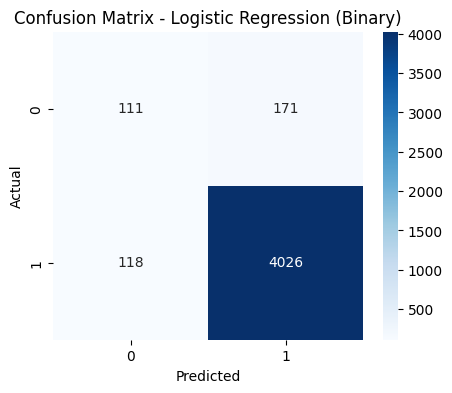

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as bin_sns
import matplotlib.pyplot as bin_plt

bin_Y_pred = bin_clf.predict(bin_X_test)
bin_cm = confusion_matrix(bin_Y_test, bin_Y_pred)
bin_plt.figure(figsize=(5,4))
bin_sns.heatmap(bin_cm, annot=True, fmt="d", cmap="Blues")
bin_plt.title("Confusion Matrix - Logistic Regression (Binary)")
bin_plt.xlabel("Predicted")
bin_plt.ylabel("Actual")
bin_plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(bin_Y_test, bin_Y_pred))
print("\nClassification Report:\n")
print(classification_report(bin_Y_test, bin_Y_pred))

Accuracy: 0.9347040216900135

Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.39      0.43       282
           1       0.96      0.97      0.97      4144

    accuracy                           0.93      4426
   macro avg       0.72      0.68      0.70      4426
weighted avg       0.93      0.93      0.93      4426



In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cont_X = cont_df.drop(['sha256', 'type'], axis=1)
cont_Y = cont_df['type'].apply(lambda v: 0 if v == 0 else 1)

cont_X_trainval, cont_X_test, cont_Y_trainval, cont_Y_test = train_test_split(
    cont_X, cont_Y, test_size=0.15, random_state=42, stratify=cont_Y
)
val_fraction = 0.15 / 0.85
cont_X_train, cont_X_val, cont_Y_train, cont_Y_val = train_test_split(
    cont_X_trainval, cont_Y_trainval, test_size=val_fraction, random_state=42, stratify=cont_Y_trainval
)

cont_scaler = StandardScaler()
cont_X_train_scaled = cont_scaler.fit_transform(cont_X_train)
cont_X_val_scaled = cont_scaler.transform(cont_X_val)
cont_X_test_scaled = cont_scaler.transform(cont_X_test)

pca = PCA(n_components=0.95)
cont_X_train_pca = pca.fit_transform(cont_X_train_scaled)
cont_X_val_pca = pca.transform(cont_X_val_scaled)
cont_X_test_pca = pca.transform(cont_X_test_scaled)

print("Original feature count:", cont_X_train.shape[1])
print("Reduced feature count with PCA:", cont_X_train_pca.shape[1])
print("\n")

print("Training set:", cont_X_train_pca.shape)
print("Validation set:", cont_X_val_pca.shape)
print("Test set:", cont_X_test_pca.shape)

cont_clf = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)
cont_clf.fit(cont_X_train_pca, cont_Y_train)

Original feature count: 142
Reduced feature count with PCA: 55


Training set: (20659, 55)
Validation set: (4427, 55)
Test set: (4428, 55)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='liblinear')

In [16]:
print("Training accuracy: {:.2f}%".format(cont_clf.score(cont_X_train_pca, cont_Y_train)*100))
print("Validation accuracy: {:.2f}%".format(cont_clf.score(cont_X_val_pca, cont_Y_val)*100))
print("Test accuracy: {:.2f}%".format(cont_clf.score(cont_X_test_pca, cont_Y_test)*100))

Training accuracy: 86.52%
Validation accuracy: 87.08%
Test accuracy: 86.74%


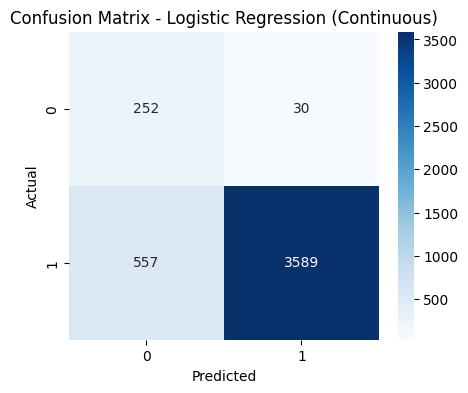

In [17]:
import seaborn as cont_sns
import matplotlib.pyplot as cont_plt

cont_Y_pred = cont_clf.predict(cont_X_test_pca)
cont_cm = confusion_matrix(cont_Y_test, cont_Y_pred)
cont_plt.figure(figsize=(5,4))
cont_sns.heatmap(cont_cm, annot=True, fmt="d", cmap="Blues")
cont_plt.title("Confusion Matrix - Logistic Regression (Continuous)")
cont_plt.xlabel("Predicted")
cont_plt.ylabel("Actual")
cont_plt.show()

In [18]:
print("Accuracy:", accuracy_score(cont_Y_test, cont_Y_pred))
print("\nClassification Report:\n")
print(classification_report(cont_Y_test, cont_Y_pred))

Accuracy: 0.8674345076784101

Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.89      0.46       282
           1       0.99      0.87      0.92      4146

    accuracy                           0.87      4428
   macro avg       0.65      0.88      0.69      4428
weighted avg       0.95      0.87      0.89      4428

